# TODO: 

- look to see if anyone has perfected method for correlating gene expression against a phenotype/trait at single cell scale.
- REPEAT PROCESS FOR GEP 22, SEND CSVS TO HOJUN. make pandas code cleaner/reusable. incorporate correction for zero inflation?
- calculate p values for each correlation (HSC, gene, GEP vs progenitor, gene, GEP). basically same thing as task 1, but separate HSCs and progenitor.

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px

from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

import statsmodels.api as sm

In [14]:
def read_metadata():
    return pd.read_csv('./data/metadata.csv').rename(columns={'Unnamed: 0': 'cell'}).set_index('cell')

def read_full_counts():
    adata = sc.read_h5ad("./data/hultcd34_full.h5ad")
    adata.obs = metadata
    df = adata.to_df()
    return df.merge(metadata, left_index=True, right_index=True)

# account for cells thrown out in cell-GEP dataframe, also keep only HSCs and progenitors
def filter_full_counts(df):
    cell_GEP_mapping = read_cell_GEP()
    gep_set = set(cell_GEP_mapping.index)
    raw_counts_set = set(df.index)
    difference = raw_counts_set.difference(gep_set)
    
    df = df[~df.index.isin(difference)]
    df = (df
          [(df['cluster'] != 'Uncommitted') | (df['subcluster'] == 'HSC')]
          .iloc[:, :-9]
         )
    
    return df

def read_cell_GEP():
    cell_GEP_mapping = pd.read_csv(r'./data/Factorized matrices from human lifetime scRNA(GEP usage per cell).csv').set_index('Cell')
    return cell_GEP_mapping.merge(metadata, left_index=True, right_index=True)
    
# keep only HSCs and progenitors
def filter_cell_GEP(cell_GEP_mapping):
    cell_GEP_mapping = (cell_GEP_mapping
                    [(cell_GEP_mapping['cluster'] != 'Uncommitted') | (cell_GEP_mapping['subcluster'] == 'HSC')]
                    .iloc[:, :35]
                   )
    return cell_GEP_mapping

In [15]:
target_GEP = 'GEP 15 (DNA Replication)'

metadata = read_metadata()
df = (read_full_counts()
      .pipe(filter_full_counts)
     )
cell_GEP_mapping = (read_cell_GEP()
                    .pipe(filter_cell_GEP)
                   )

In [ ]:
# # initialize full counts dataframe
# adata = sc.read_h5ad("./data/hultcd34_full.h5ad")
# metadata = pd.read_csv('./data/metadata.csv').rename(columns={'Unnamed: 0': 'cell'}).set_index('cell')
# adata.obs = metadata
# df = adata.to_df()
# df = (df
#      .merge(metadata, left_index=True, right_index=True)
#      )


# # initialize cell-GEP dataframe
# cell_GEP_mapping = pd.read_csv(r'./data/Factorized matrices from human lifetime scRNA(GEP usage per cell).csv').set_index('Cell')
# cell_GEP_mapping = (cell_GEP_mapping
#           .merge(metadata, left_index=True, right_index=True)
#          )


# # account for cells thrown out in cell-GEP dataframe
# gep_set = set(cell_GEP_mapping.index)
# raw_counts_set = set(df.index)
# difference = raw_counts_set.difference(gep_set)
# df = df[~df.index.isin(difference)]


# # query to keep only HSCs and progenitors
# cell_GEP_mapping = (cell_GEP_mapping
#                     [(cell_GEP_mapping['cluster'] != 'Uncommitted') | (cell_GEP_mapping['subcluster'] == 'HSC')]
#                     .iloc[:, :35]
#                    )
# df = (df
#       [(df['cluster'] != 'Uncommitted') | (df['subcluster'] == 'HSC')]
#       .iloc[:, :-9]
#       )

task 1 -

look at HSCs and progenitors together. plot gene exp (x) vs GEP 15 output (y). do some regression hypothesis testing and use multiple testing correction (Bonferoni correction)

In [4]:
def calculate_p_all_cells(row):
    X = row
    y = cell_GEP_mapping[target_GEP]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    p_value = model.pvalues.iloc[1]
    
    all_res[row.name] = p_value
    
def dict_to_df_p(res):
    df = pd.DataFrame.from_dict(res, orient='index', columns=['p-value'])
    df.index.name = 'gene'
    return df

In [5]:
all_res = {}
df.apply(calculate_p_all_cells)
all_cell_p = dict_to_df_p(all_res)

cutoff = 0.001 / df.shape[0]
all_cell_significant = all_cell_p[all_cell_p['p-value'] < cutoff]

(array([10423.,   219.,   122.,    95.,    74.,    58.,    62.,    49.,
           40.,    51.]),
 array([0.00000000e+00, 2.42890195e-09, 4.85780390e-09, 7.28670585e-09,
        9.71560779e-09, 1.21445097e-08, 1.45734117e-08, 1.70023136e-08,
        1.94312156e-08, 2.18601175e-08, 2.42890195e-08]),
 <BarContainer object of 10 artists>)

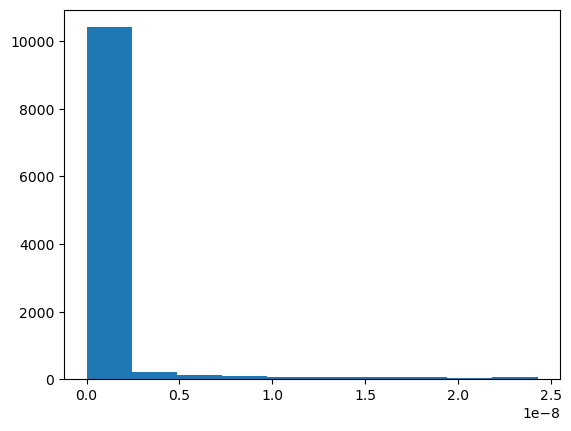

In [6]:
plt.hist(all_cell_significant['p-value'])

In [7]:
all_cell_significant.sort_values('p-value')

,p-value
gene,
EXOSC8,0.000000e+00
H2AFY,0.000000e+00
H2AFZ,0.000000e+00
H3F3A,0.000000e+00
FEN1,0.000000e+00
...,...
HORMAD2.AS1,2.387311e-08
LOXHD1,2.402809e-08
PARD6G.AS1,2.407749e-08


task 2 -

for each gene:

separate HSCs and progenitors.

calculate 2 r values (one for HSCs only and other progenitors only) for gene expression (df cols) to predict GEP 15

compare abs difference in r

In [8]:
target = cell_GEP_mapping[[target_GEP]]

merged = (df
      .merge(target, left_index=True, right_index=True)
      .merge(metadata, left_index=True, right_index=True)
      )

hsc = merged[merged['subcluster'] == 'HSC'].iloc[:, :-9]
hsc_X = hsc.iloc[:, :-1]
hsc_y = hsc['GEP 15 (DNA Replication)']

prog = merged[merged['cluster'] != 'Uncommitted'].iloc[:, :-9]
prog_X = prog.iloc[:, :-1]
prog_y = prog['GEP 15 (DNA Replication)']

NameError: name 'metadata' is not defined

In [ ]:
def calculate_r_hsc(row):
    X = row
    y = hsc_y
    hsc_res[row.name] = np.corrcoef(X, y)[0, 1]
    
def calculate_r_prog(row):
    X = row
    y = prog_y
    prog_res[row.name] = np.corrcoef(X, y)[0, 1]
    
def dict_to_df_r_HSC(res):
    df = pd.DataFrame.from_dict(res, orient='index', columns=['r hsc'])
    df.index.name = 'gene'
    return df

def dict_to_df_r_prog(res):
    df = pd.DataFrame.from_dict(res, orient='index', columns=['r prog'])
    df.index.name = 'gene'
    return df

In [ ]:
hsc_res = {}
hsc_X.apply(calculate_r_hsc)
hsc_r = dict_to_df_r_HSC(hsc_res)

prog_res = {}
prog_X.apply(calculate_r_prog)
prog_r = dict_to_df_r_prog(prog_res)

In [9]:
all_r = hsc_r.merge(prog_r, left_index=True, right_index=True)
all_r['abs diff'] = (all_r['r hsc'] - all_r['r prog']).abs()

NameError: name 'hsc_r' is not defined

In [ ]:
# all_r.to_csv('GEP15_correlation.csv', index=True)

In [ ]:
(all_r
 .sort_values('abs diff', ascending=False)
 .head(20)
)

In [ ]:
plt.hist(all_r['r prog'], alpha=0.5, label='r prog')
plt.hist(all_r['r hsc'], alpha=0.5, label='r hsc')
plt.legend()
plt.show()

In [ ]:
all_r['r prog'].describe()

In [ ]:
all_r['r hsc'].describe()

In [ ]:
plt.scatter(hsc_X['EIF4B'], hsc_X['MT.ND2'])

In [ ]:
x = hsc_X['EIF4B']
y = hsc_y

# plt.xlim(0, 80)
# plt.ylim(0, 10)
plt.scatter(np.log(x), y)

In [ ]:
x = prog_X['EIF4B']
y = prog_y

plt.scatter(np.log(x), y)
# plt.xlim(0, 80)
# plt.ylim(0, 10)
plt.show()

https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02601-5 - zero inflation

https://pmc.ncbi.nlm.nih.gov/articles/PMC7412673/ - hippo